In [1]:
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from torchsummary import summary
from safetensors.torch import save_model, load_model
import matplotlib.pyplot as plt
import cv2

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Data Manipulation

In [3]:
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [4]:
dataset = datasets.ImageFolder(root="data/Skyfinder/picked", transform=data_transforms)

train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

In [5]:
batch_size = 16

# put custom dataset to dataloader
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
# check shapes of dataloader
feature, label = next(iter(train_dl))
feature.shape, label.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16]))

### Create Model

A VAE is just like an Autoencoder but the latent vector is now represnted as Gaussians

In [7]:
input_dim = 3*128*128
output_dim = input_dim
hidden_dim = 512
latent_dim = 32

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim):
        super(Encoder, self).__init__()

        self.en_input = nn.Linear(input_dim, hidden_dim)
        self.en_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.en_mean = nn.Linear(hidden_dim, latent_dim)
        self.en_var = nn.Linear(hidden_dim, latent_dim)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.en_input(x)
        x = self.relu(x)

        x = self.en_hidden(x)
        x = self.relu(x)

        mean = self.en_mean(x) # means and variance under log
        var = self.en_var(x)

        return mean, var

In [9]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=input_dim):
        super(Decoder, self).__init__()

        self.de_input = nn.Linear(latent_dim, hidden_dim)
        self.de_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.de_out = nn.Linear(hidden_dim, output_dim)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.de_input(x)
        x = self.relu(x)

        x = self.de_hidden(x)
        x = self.relu(x)

        x = self.de_out(x)
        x = torch.sigmoid(x)

        return x

In [10]:
class VAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(VAE, self).__init__()

        self.Encoder = Encoder
        self.Decoder = Decoder

    def rep(self, mean, var):
        e = torch.randn_like(var).to(device)
        z = mean + var * e
        return z
    
    def forward(self, x):
        mean, var = self.Encoder(x)
        z = self.rep(mean, torch.exp(0.5 * var)) # log var -> var
        x = self.Decoder(z)

        return x, mean, var

encoder = Encoder()
decoder = Decoder()
model = VAE(Encoder=encoder, Decoder=decoder).to(device)

summary(model, (16, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 16, 512]      25,166,336
              ReLU-2              [-1, 16, 512]               0
            Linear-3              [-1, 16, 512]         262,656
              ReLU-4              [-1, 16, 512]               0
            Linear-5               [-1, 16, 32]          16,416
            Linear-6               [-1, 16, 32]          16,416
           Encoder-7  [[-1, 16, 32], [-1, 16, 32]]               0
            Linear-8              [-1, 16, 512]          16,896
              ReLU-9              [-1, 16, 512]               0
           Linear-10              [-1, 16, 512]         262,656
             ReLU-11              [-1, 16, 512]               0
           Linear-12            [-1, 16, 49152]      25,214,976
          Decoder-13            [-1, 16, 49152]               0
Total params: 50,956,352
Trainable p

### Optimizer and Custom Loss Function

In [11]:
def loss_fn(x, x_hat, mean, log_var):

    # loss for reproduction
    bce = nn.BCELoss(reduction="sum")
    rep_loss = bce(x_hat, x)

    # loss for comparing distributions (Kullback–Leibler divergence)
    kld = -0.5 *  torch.sum(1+log_var-mean.pow(2)-log_var.exp())

    return rep_loss + kld

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Training Model

In [12]:
torch.manual_seed(42)

epochs = 30

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    
    # TRAINING
    train_loss =  0
    model.train()
    for batch, (X, y) in enumerate(train_dl):

        if X.shape[0] != 16:
            continue

        X, y = X.view(batch_size, input_dim).to(device), y.to(device)

        # forward pass
        train_x_hat, train_mean, train_log_var = model(X)

        # metrics
        loss = loss_fn(X, train_x_hat, train_mean, train_log_var)
        train_loss += loss

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # print metrics
    train_loss /= len(train_dl)
    print(f"Train Loss: {train_loss:.4f}")

    
    # TESTING
    test_loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in test_dl:

            if X.shape[0] != 16:
                continue

            X, y = X.view(batch_size, input_dim).to(device), y.to(device)

            # forward pass
            test_x_hat, test_mean, test_var = model(X)

            # metrics
            test_loss += loss_fn(X, test_x_hat, test_mean, test_var)

        # print metrics
        test_loss /= len(test_dl)
        print(f"Test Loss: {test_loss:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
------


  3%|▎         | 1/30 [00:01<00:29,  1.00s/it]

Train Loss: 488638.1875
Test Loss: 364560.5625
Epoch: 1
------


  7%|▋         | 2/30 [00:01<00:22,  1.25it/s]

Train Loss: 434796.8750
Test Loss: 344113.4375
Epoch: 2
------


 10%|█         | 3/30 [00:02<00:20,  1.34it/s]

Train Loss: 416085.1562
Test Loss: 327548.8750
Epoch: 3
------


 13%|█▎        | 4/30 [00:03<00:18,  1.39it/s]

Train Loss: 400554.8750
Test Loss: 319959.6250
Epoch: 4
------


 17%|█▋        | 5/30 [00:03<00:17,  1.44it/s]

Train Loss: 392651.8750
Test Loss: 314451.8438
Epoch: 5
------


 20%|██        | 6/30 [00:04<00:16,  1.43it/s]

Train Loss: 386769.1562
Test Loss: 310233.4375
Epoch: 6
------


 23%|██▎       | 7/30 [00:05<00:16,  1.41it/s]

Train Loss: 384135.4062
Test Loss: 308638.2500
Epoch: 7
------


 27%|██▋       | 8/30 [00:05<00:15,  1.42it/s]

Train Loss: 377483.4688
Test Loss: 310607.9375
Epoch: 8
------


 30%|███       | 9/30 [00:06<00:14,  1.45it/s]

Train Loss: 373084.5625
Test Loss: 302091.7500
Epoch: 9
------


 33%|███▎      | 10/30 [00:07<00:13,  1.47it/s]

Train Loss: 370627.0625
Test Loss: 299581.0000
Epoch: 10
------


 37%|███▋      | 11/30 [00:07<00:12,  1.47it/s]

Train Loss: 370195.5625
Test Loss: 299826.1250
Epoch: 11
------


 40%|████      | 12/30 [00:08<00:12,  1.47it/s]

Train Loss: 366920.0938
Test Loss: 298856.2812
Epoch: 12
------


 43%|████▎     | 13/30 [00:09<00:11,  1.47it/s]

Train Loss: 368950.9688
Test Loss: 297526.6250
Epoch: 13
------


 47%|████▋     | 14/30 [00:09<00:10,  1.49it/s]

Train Loss: 364370.5625
Test Loss: 297655.8438
Epoch: 14
------


 50%|█████     | 15/30 [00:10<00:10,  1.43it/s]

Train Loss: 364869.0000
Test Loss: 297243.3125
Epoch: 15
------


 53%|█████▎    | 16/30 [00:11<00:09,  1.44it/s]

Train Loss: 366624.6562
Test Loss: 295690.4375
Epoch: 16
------


 57%|█████▋    | 17/30 [00:11<00:08,  1.46it/s]

Train Loss: 363926.9375
Test Loss: 296887.5938
Epoch: 17
------


 60%|██████    | 18/30 [00:12<00:08,  1.48it/s]

Train Loss: 362897.0000
Test Loss: 295618.9688
Epoch: 18
------


 63%|██████▎   | 19/30 [00:13<00:07,  1.50it/s]

Train Loss: 362450.8125
Test Loss: 295120.6875
Epoch: 19
------


 67%|██████▋   | 20/30 [00:13<00:06,  1.52it/s]

Train Loss: 363841.1250
Test Loss: 296117.3438
Epoch: 20
------


 70%|███████   | 21/30 [00:14<00:05,  1.52it/s]

Train Loss: 363629.7812
Test Loss: 295394.5938
Epoch: 21
------


 73%|███████▎  | 22/30 [00:15<00:05,  1.54it/s]

Train Loss: 362782.3750
Test Loss: 294362.2188
Epoch: 22
------


 77%|███████▋  | 23/30 [00:15<00:04,  1.55it/s]

Train Loss: 362142.1562
Test Loss: 296377.4062
Epoch: 23
------


 80%|████████  | 24/30 [00:16<00:03,  1.56it/s]

Train Loss: 362002.2188
Test Loss: 299926.0625
Epoch: 24
------


 83%|████████▎ | 25/30 [00:17<00:03,  1.56it/s]

Train Loss: 363596.6562
Test Loss: 293794.5938
Epoch: 25
------


 87%|████████▋ | 26/30 [00:17<00:02,  1.52it/s]

Train Loss: 362272.2188
Test Loss: 294519.8750
Epoch: 26
------


 90%|█████████ | 27/30 [00:18<00:01,  1.53it/s]

Train Loss: 362749.5000
Test Loss: 297833.7500
Epoch: 27
------


 93%|█████████▎| 28/30 [00:19<00:01,  1.51it/s]

Train Loss: 360931.7500
Test Loss: 295165.1562
Epoch: 28
------


 97%|█████████▋| 29/30 [00:19<00:00,  1.41it/s]

Train Loss: 361664.7812
Test Loss: 293629.3125
Epoch: 29
------


100%|██████████| 30/30 [00:20<00:00,  1.46it/s]

Train Loss: 359071.6562
Test Loss: 294054.5312


### Testing Model

With images that its trained on

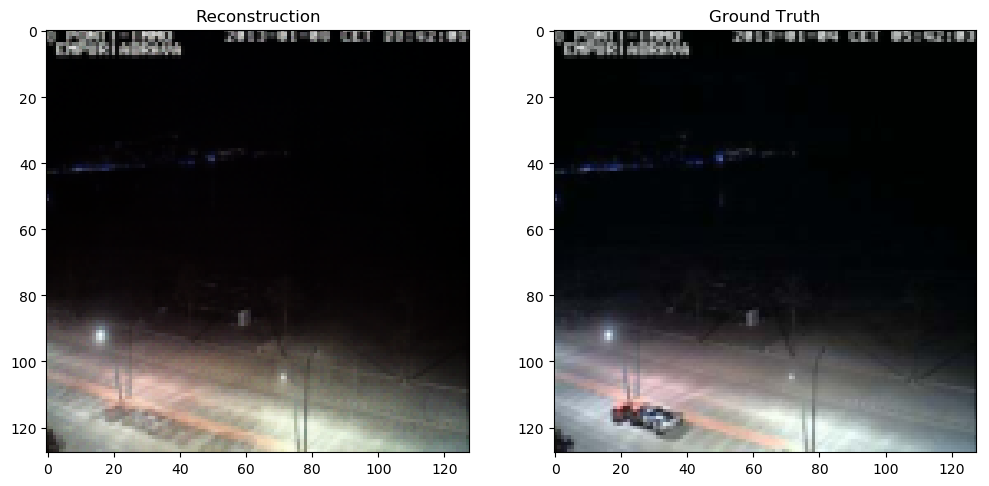

In [25]:
X, y = next(iter(train_dl))
X, y = X[8, :, :].view(input_dim).to(device), y[0].to(device)

sample_reconst, sample_mean, sample_var = model(X)
sample_reconst = sample_reconst.reshape(3, 128, 128).permute(1, 2, 0).detach().cpu().numpy()

X_img = X.reshape(3, 128, 128).permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=(12, 8))

plt.subplot(121)
plt.title("Reconstruction")
plt.imshow(sample_reconst)

plt.subplot(122)
plt.title("Ground Truth")
plt.imshow(X_img)

With images its never seen (bad)

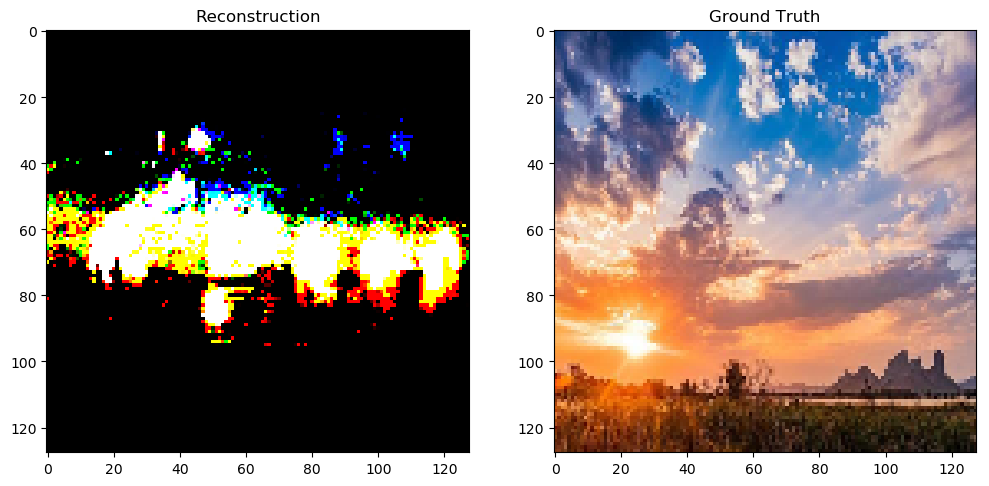

In [30]:
test_img = cv2.imread("v.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img, (128, 128))
test_tensor = torch.from_numpy(test_img).permute(2, 0, 1).reshape(input_dim).type(torch.float32).to(device)

sample_reconst, sample_mean, sample_var = model(test_tensor)
sample_reconst = sample_reconst.reshape(3, 128, 128).permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=(12, 8))

plt.subplot(121)
plt.title("Reconstruction")
plt.imshow(sample_reconst)

plt.subplot(122)
plt.title("Ground Truth")
plt.imshow(test_img)